# Projeto 1 - Predição da precificação de casas 
## House Sales in King County, USA - Kaggle

## Introdução

Este é um conjunto de dados armazenado no Kaggle, uma plataforma de estudo e competições de Ciência de Dados. Segue a tradução sobre o conjunto de dados.

**"Este conjunto de dados contém preços de venda de casas para King County, que inclui Seattle. Inclui casas vendidas entre maio de 2014 e maio de 2015."**

Segue a descrição das variaveis:

- id - identificação unica para cada venda
- date - data da venda
- price - preço da venda
- bedrooms - número de quartos
- bathrooms - número de banheiros
- sqft_living - tamanho da casa em metros quadrados
- sqft_lot - tamanho do lote em metros quadrados
- floors - número de andares
- waterfront - vista para praia
- view - visitado
- condition - condição da casa
- grade - nota de qualidade (baseado no sistema de classificação do King County)
- sqft_above - tamanho da área abaixo da casa em metros quadrados
- sqft_basement - tamanho do porão em metros quadrados
- yr_built - ano de construção
- yr_renovated - ano da ultima reforma
- zipcode - CEP
- lat - latitude
- long - longitude
- sqft_living15 - área da casa em 2015 (implica a algumas reformas). Isso pode ou não ter afetado a área do lote
- sqft_lot15 - área do lote em 2015 (implica a algumas reformas)

# Preparação do ambiente

- Acessem o link - https://www.kaggle.com/datasets/harlfoxem/housesalesprediction e logo abaixo cliquem em "Download". Caso voce não tenha uma conta no Kaggle, crie uma e retorne para esse ponto para realizar o download.

In [8]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import SVG, display
import plotly.io as pio

In [2]:
df_casas = pd.read_csv(r'E:\Blue\Módulo 2\Projetos\projeto_01\Dados\kc_house_data.csv')

Formule ao menos duas perguntas que você acha que poderiam ser respondidas usando os dados

**PERGUNTA 1**: É mais importante o tamanho do lote ou o tamanho da casa para analisar o preço?

**PERGUNTA 2**: O número de andares afeta diretamente o preço final do estabelecimento?

É interessante mostrar um gráfico e comparação de metricas representando o problema da primeira pergunta, pois apresentam uma proposta mais de comparação de dados e as metrícas e os gráficos são mais interessantes. É mais interessante gerar um gráfico de linhas de tamanho da casa x preço e tamanho do lote x preço e analisar o comportamento dos dados, depois gerar as métricas.

Para o segundo é importante gerar um gráfico para visualizar os dados e depois gerar a equação da reta para saber o comportamento do preço em cima do número de andares


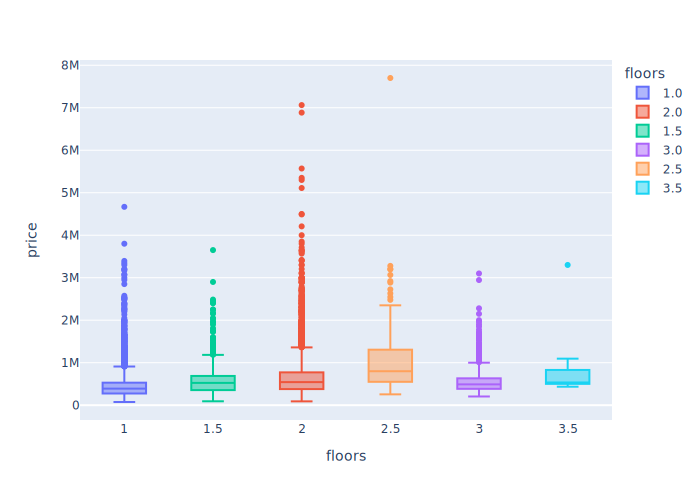

In [3]:
fig = px.box(df_casas, x= 'floors', y = 'price',color = 'floors')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

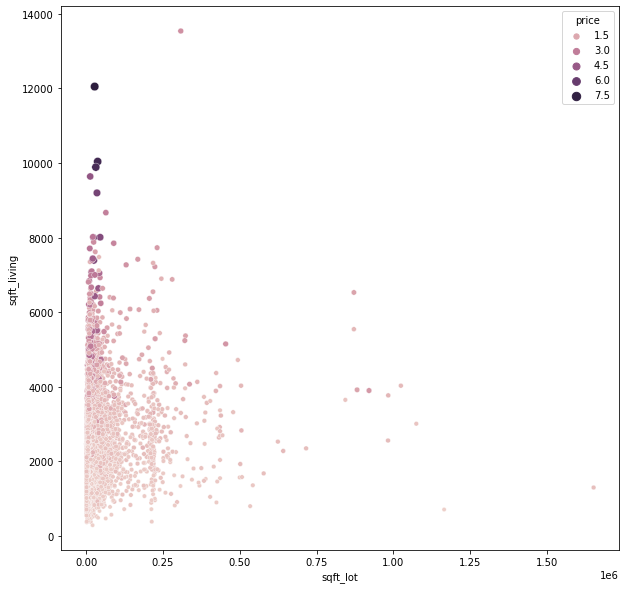

In [16]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'sqft_lot',y='sqft_living', hue = 'price',size = 'price', data=df_casas)
plt.show()

Podemos dividir o problema em duas partes, mas de maneira geral, não responde.

Pontos da primeira pergunta:

- O primeiro ponto a ser destacado é que o valor do preço mínimo e do preço máximo não aumentam proporcionalmente ao número de andares;
- Pode-se destacar que o primeiro quartil, terceiro quartil e a variação entre quartis não varia em torno do número de andares;
- Existem outliers em todas as variaveis de andar;
- O gráfico não atende as espectativas.

Pontos da segunda pergunta:

- É possível perceber que os pontos dependem muito mais do tamanho da casa do que do tamanho do terreno;
- Existe um ponto que possui a maior área de terreno e possui um preço baixo por possuir uma baixa área de tamanho da casa;
- Existe um outlier em que este possui a maior área de tamanho da casa e possui um preço mediano, seria necessários maiores estudos para classificar essa variável;
- O gráfico atende parcialmente as espectativas.

In [ ]:
df_casas['sqmeter_living'] = df_casas['sqft_living'].apply((lambda x: x*0.0929)) #Transformação em de pés quadrados em metros quadrados
print(df_casas['sqmeter_living'].describe())
print(df_casas.shape)


count    21613.000000
mean       193.222685
std         85.323159
min         26.941000
25%        132.568300
50%        177.439000
75%        236.895000
max       1257.866000
Name: sqmeter_living, dtype: float64
(21613, 22)


In [ ]:
print('Existem {} observações no conjunto de dados'.format('21613'))
print('Existem {} variaveis no conjunto de dados'.format('21'))
print('O tamanho médio das casa é de {} metros quadrados'.format('193.22'))
print('A mediana do tamanho das casas é de {} metros quadrados'.format('177.439'))

print('primeiro quartil {} do tamanho das casas'.format('132.568'))
print('terceiro quartil {} do tamanho das casas'.format('236.895'))

Existem 21613 observações no conjunto de dados
Existem 21 variaveis no conjunto de dados
O tamanho médio das casa é de 193.22 metros quadrados
A mediana do tamanho das casas é de 177.439 metros quadrados
primeiro quartil 132.568 do tamanho das casas
terceiro quartil 236.895 do tamanho das casas


Neste conjunto de dados há casas com tamanho muito acima ou abaixo do esperado (outliers)? Faça um gráfico de caixa (boxplot) do tamanho das casas.

In [ ]:
valores_bool =  df_casas['sqmeter_living'].apply(lambda x: x >=392.967) # Lista com os valores da coluna do tamanho
valores_abaixo_upper = df_casas.loc[df_casas['sqmeter_living'] < 392.967, ['sqmeter_living']] # O valor de 1778.992 correponde ao valor do "upper fence" que é onde os pontos tem uma maior taxa de agrupamento
valores_bool.value_counts(normalize = True)

False    0.973025
True     0.026975
Name: sqmeter_living, dtype: float64

In [ ]:
fig = px.box(df_casas, x = 'sqmeter_living', points = 'all')
img_bytes = pio.to_image(fig, format="svg")
display(SVG(img_bytes))

Existe um alto agrupamento no gráfico na região entre o minimo e o upper fence (lê-se upper fence o valor do terceiro quartil somado com 1,5 * IQR, sendo IQR a distância entre quartis ou *interquarile range*), todavia depois da upper fence existe uma disseminação reduzida de pontos, a partir de 745 metros quadrados inicia-se uma quantidade muito alta do valor da variável estudada. Vale destacar que os valores acima de outliers são apenas 2.7 (arrendodado) dos valores estudados, talvez seja interessante retirar-los para que a analise tenha uma maior precisão.
 
Agora tocante a pergunta efetuada, parece existir um outlier minimo, mas a variação dele não parece ser impactante, todavia quando analisamos os valores acima de 750 existe uma variação muito alta dos valores, podendo caracterizar possiveis outliers.

In [ ]:
#conversão da cedula date em ano/mês/dia (está em um formado estranho, mas dá para perceber o formato da data)
df_date = df_casas['date'].str.replace('T000000', '')
df_date = pd.to_datetime(df_date)
df_date = df_date.astype('str')
df_date = df_date.str.split('-', expand= True)
df_date = df_date.astype('int64')
df_casas = df_casas.join(df_date)
df_casas = df_casas.rename(columns = {0 : 'year', 1: 'month', 2:'day'})
df_casas = df_casas.drop(['zipcode','id','date'], axis = 1)

In [ ]:
a = df_casas['yr_renovated'] == 0
a = a.rename('age')
for i in range(len(df_casas)):
    if a[i] == True:
        a[i] = df_casas.loc[i,'year'] - df_casas.loc[i,'yr_built']
    else:
        a[i] = df_casas.loc[i,'year'] - df_casas.loc[i,'yr_renovated']
a = a.astype('int64')
df_casas = df_casas.drop(['yr_renovated','yr_built','year'], axis = 1)
df_casas = pd.concat([df_casas,a], axis = 1)

In [ ]:
def modelo_problema1():
    X_prob1 = df_casas.drop(['price'], axis = 1)
    X_prob1 = sm.add_constant(X_prob1)
    y_prob1 = df_casas['price']
    model1 = sm.OLS(exog = X_prob1, endog = y_prob1)
    result1 = model1.fit()
    return result1.summary()

In [ ]:
modelo_problema1()

c:\Users\augus\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     2780.
Date:                Fri, 27 May 2022   Prob (F-statistic):               0.00
Time:                        23:46:03   Log-Likelihood:            -2.9507e+05
No. Observations:               21613   AIC:                         5.902e+05
Df Residuals:                   21595   BIC:                         5.903e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.812e+07   1.54e+06    -31.246      0.000   -5.11e+07   -4.51e+07
bedrooms       -3.404e+04   1931.196    -17.626      0.000   -3.78e+04   -3.03e+04
bathrooms       3.736e+04   3327.453     11.229      0.000    3.08e+04    4.39e+04
sqft_living      114.1400      2.294     49.766      0.000     109.645     118.635
sqft_lot           0.1397      0.049      2.853      0.004       0.044       0.236
floors         -4509.2134   3660.108     -1.232      0.218   -1.17e+04    2664.868
waterfront      6.041e+05   1.77e+04     34.103      0.000    5.69e+05    6.39e+05
view            5.377e+04   2171.316     24.764      0.000    4.95e+04     5.8e+04
condition       3.156e+04   2397.145     13.165      0.000    2.69e+04    3.63e+04
grade           9.219e+04   2193.657     42.027      0.000    8.79e+04    9.65e+04
sqft_above        72.7223      2.301     31.602      0.000      68.212      77.233
sqft_basement     41.4177      2.696     15.366      0.000      36.134      46.701
lat             5.837e+05   1.07e+04     54.681      0.000    5.63e+05    6.05e+05
long           -1.606e+05   1.21e+04    -13.305      0.000   -1.84e+05   -1.37e+05
sqft_living15     22.8441      3.506      6.517      0.000      15.973      29.715
sqft_lot15        -0.3820      0.075     -5.101      0.000      -0.529      -0.235
sqmeter_living    10.6037      0.213     49.767      0.000      10.186      11.021
month          -2695.3137    450.392     -5.984      0.000   -3578.116   -1812.512
day             -400.3317    162.397     -2.465      0.014    -718.641     -82.022
age             1980.2047     72.642     27.260      0.000    1837.821    2122.588
==============================================================================
Omnibus:                    18476.355   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1843496.717
Skew:                           3.603   Prob(JB):                         0.00
Kurtosis:                      47.667   Cond. No.                     1.17e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.01e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Variáveis para reduzir o tamanho do comando
scalor = StandardScaler()
lr = LinearRegression()
def modelo_sklearn():
    X = df_casas.drop(['price'], axis = 1)
    y = df_casas.price
    X_std = scalor.fit_transform(X)
    #Código de previsão das variáveis preditivas normalizadas
    y_norm = y/y.max()
    X_train, X_test, y_train, y_test = train_test_split(X_std, y_norm, test_size= 0.3, random_state=10)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    #Código de previsão das variáveis preditivas não normalizadas
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_std, y, test_size= 0.3, random_state=10)
    lr.fit(X_train2, y_train2)
    y_pred2 = lr.predict(X_test2)
    r2score = 'O valor do R² é  {:.03f}'.format(r2_score(y_test, y_pred))
    mae_norm = 'O valor do MAE normalizado é {:.03f}'.format(mean_absolute_error(y_test, y_pred))
    mae_nao_norm = 'O valor do MAE não normalizado é: {:.03f}'.format(mean_absolute_error(y_test2, y_pred2))
    return r2score + '\n' +  mae_norm + '\n' + mae_nao_norm

In [ ]:
print(modelo_sklearn())

O valor do R² é  0.691
O valor do MAE normalizado é 0.016
O valor do MAE não normalizado é: 125898.882


In [ ]:
X = df_casas.drop(['price','sqmeter_living'], axis = 1) #sqmeter_living = sqft_living o que muda é a unidade
y = df_casas.price
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step = 1)
selector.fit(X,y)
selector_features = pd.Series(selector.feature_names_in_, name = 'feature names')
selector_ranking = pd.Series(selector.ranking_, name = 'ranking')
selector1 = pd.concat([selector_ranking,selector_features], axis = 1)
selector1 = selector1.sort_values(by='ranking',ascending=True)
selector1.head()

ranking feature names
8         1         grade
12        1          long
11        1           lat
5         1    waterfront
6         1          view

In [ ]:
def melhores_variaveis():
    X = df_casas[['waterfront', 'sqft_living', 'sqft_basement', 'lat', 'sqft_above']] #foi gerado um get_feature_names_out() na cedula abaixo com os mais importantes
    y = df_casas.price
    X_std = scalor.fit_transform(X)
    #Código de previsão das variáveis preditivas normalizadas
    y_norm = y/y.max()
    X_train, X_test, y_train, y_test = train_test_split(X_std, y_norm, test_size= 0.3, random_state=10)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    #Código de previsão das variáveis preditivas não normalizadas
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_std, y, test_size= 0.3, random_state=10)
    lr.fit(X_train2, y_train2)
    y_pred2 = lr.predict(X_test2)
    r2score = 'O valor do R² é  {:.03f}'.format(r2_score(y_test, y_pred))
    mae_norm = 'O valor do MAE normalizado é {:.03f}'.format(mean_absolute_error(y_test, y_pred))
    mae_nao_norm = 'O valor do MAE não normalizado é: {:.03f}'.format(mean_absolute_error(y_test2, y_pred2))
    return r2score + '\n' +  mae_norm + '\n' + mae_nao_norm

In [ ]:
selector.get_feature_names_out()

array(['waterfront', 'view', 'grade', 'lat', 'long'], dtype=object)

In [ ]:
print(melhores_variaveis())

O valor do R² é  0.622
O valor do MAE normalizado é 0.019
O valor do MAE não normalizado é: 145971.966
